# Imports

In [3]:
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

# Load Data

In [11]:
nopre = pd.read_csv('../data_files/9.0.0/all.csv', index_col=[0])
nopre = nopre['Lb_M'][nopre['category']==1].to_numpy() # Only select the signal events

pre = pd.read_csv('../data_files/9.0.1/all.csv', index_col=[0])
pre = pre['Lb_M'][pre['category']==1].to_numpy()

nopre = nopre[np.logical_and(nopre < 6500, nopre > 4500)]
pre = pre[np.logical_and(pre < 6500, pre > 4500)]

# Plot Distributions

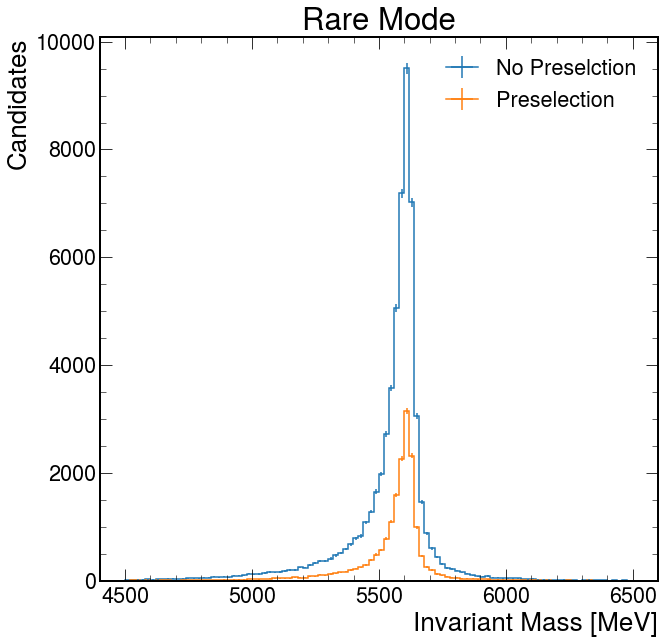

In [15]:
fnpre, bins = np.histogram(nopre, bins=100)
fpre, _ = np.histogram(pre, bins=bins)

fig, ax = plt.subplots(1, 1)
hep.histplot([fnpre, fpre], yerr=True, bins=bins, ax=ax, label=['No Preselction', 'Preselection'])
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Candidates')
plt.legend()
plt.title('Rare Mode')
plt.show()

In [16]:
def fitDoubleCB(np_data, label, mass_ranges=[4000, 6500], param_ranges=[[5600, 5500, 5700],[20, 10, 50],[1, 0, 2],[4, 0.1, 10],[1, 0, 2],[4, 0.1, 10],[30000, 0, 100000]]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, *param_ranges[0])
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, *param_ranges[1])
    alpha_l = zfit.Parameter('alpha_l_%s'%label, *param_ranges[2])
    n_l = zfit.Parameter('n_l_%s'%label, *param_ranges[3])
    alpha_r = zfit.Parameter('alpha_r_%s'%label, *param_ranges[4])
    n_r = zfit.Parameter('n_r_%s'%label, *param_ranges[5])
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('DCB_yield_%s'%label, *param_ranges[6], step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb)
    
    return dcb_ext, fitResult, MC_LbM

In [17]:
npmodel, npresult, npmasses = fitDoubleCB(nopre, "nopre")
pmodel, presult, pmasses = fitDoubleCB(pre, "pre")

2022-04-05 16:56:24.062089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-05 16:56:24.062151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-05 16:56:24.062197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eprexb.ph.bham.ac.uk): /proc/driver/nvidia/version does not exist
2022-04-05 16:56:24.063214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 16:56:24.151004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [21]:
print(f"No Preselection\n===============\nResult Converged: {npresult.converged}\nResult Valid: {npresult.valid}")
print(f"\nPreselection\n============\nResult Converged: {presult.converged}\nResult Valid: {presult.valid}")

No Preselection
Result Converged: True
Result Valid: True

Preselection
Result Converged: True
Result Valid: True


In [24]:
np_param_errors = npresult.errors()
p_param_errors = presult.errors()

print(npresult.params, '\n')
print(presult.params)

name               value         minuit_minos    at limit
---------------  -------  -------------------  ----------
DCB_yield_nopre    58600  -2.4e+02   +2.4e+02       False
alpha_l_nopre     0.4249  -  0.013   +  0.013       False
alpha_r_nopre      1.137  -  0.029   +  0.028       False
mu_CB_nopre         5612  -   0.42   +   0.42       False
n_l_nopre          2.807  -  0.041   +  0.042       False
n_r_nopre          2.009  -  0.039   +   0.04       False
sigma_CB_nopre     21.55  -   0.62   +    0.6       False 

name             value         minuit_minos    at limit
-------------  -------  -------------------  ----------
DCB_yield_pre    18130  -1.3e+02   +1.3e+02       False
alpha_l_pre     0.4656  -  0.022   +  0.021       False
alpha_r_pre      1.219  -  0.046   +  0.045       False
mu_CB_pre         5612  -   0.64   +   0.66       False
n_l_pre          2.869  -  0.074   +  0.077       False
n_r_pre          1.896  -  0.064   +  0.065       False
sigma_CB_pre     21.99  -   

Chi2 = 1.8


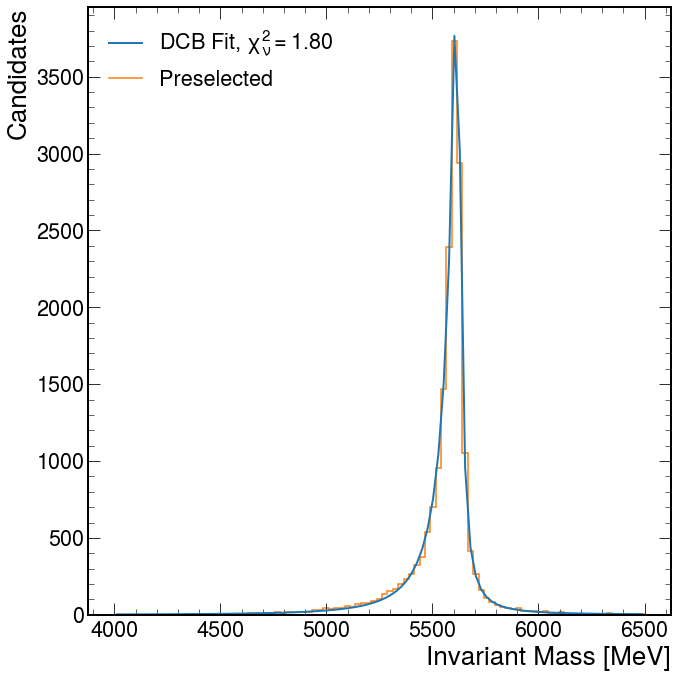

In [37]:
fig, ax = plt.subplots(1, 1)
labels = ['Preselected', 'No Preselection']
i = 0

for model, data in zip([pmodel], [pmasses]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    ax.plot(x, y, linewidth=2, label=r'DCB Fit, $\chi^2_{\nu}=1.80$')
    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])

    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    print("Chi2 = %.2g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(pmodel.get_params()))))
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel('Invariant Mass [MeV]')
plt.legend()
plt.tight_layout()
plt.savefig('../images/signalfits/Unbinned_DCB_Preselected.png')
plt.show()

# Normalisation Mode
## Load Data

In [45]:
pre = pd.read_csv('../data_files/8.0.0/all.csv', index_col=[0])
pre = pre[pre['QSQR'].between(3000, 3718)]
pre = pre['Lb_M'][pre['category']==1].to_numpy()
# Remember that Dan has already applied the pre-selection
pre = pre[np.logical_and(pre < 5800, pre > 5200)]

## Plot Data

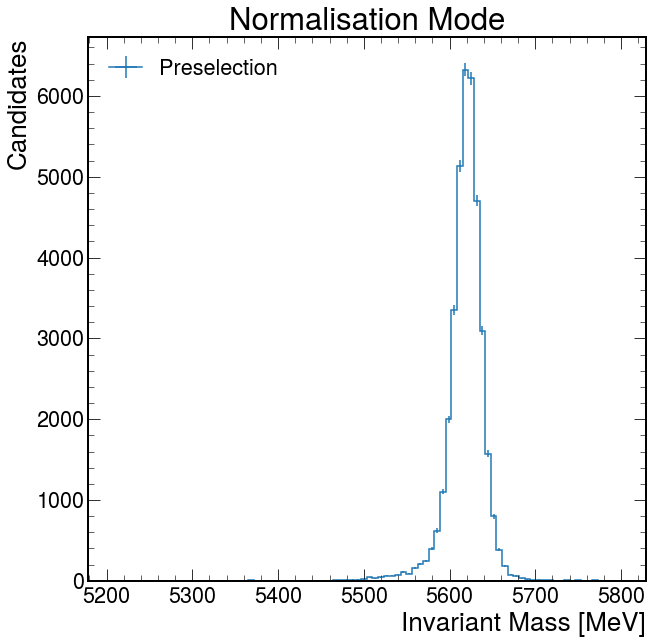

In [46]:
fpre, bins = np.histogram(pre, bins=90)
fig, ax = plt.subplots(1, 1)
hep.histplot(fpre, yerr=True, bins=bins, ax=ax, label='Preselection')
plt.xlabel('Invariant Mass [MeV]')
plt.ylabel('Candidates')
plt.legend()
plt.title('Normalisation Mode')
plt.show()

# Fit Data

In [49]:
model, result, space = fitDoubleCB(pre, 'Norm2', mass_ranges=[5200, 5800])

print(f"\nPreselection\n============\nResult Converged: {result.converged}\nResult Valid: {result.valid}")


Preselection
Result Converged: True
Result Valid: True


In [50]:
param_errors = result.errors()

print(result.params)

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/minimizers/fitresult.py:1115: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


name               value         minuit_minos    at limit
---------------  -------  -------------------  ----------
DCB_yield_Norm2    37370  -1.9e+02   +1.9e+02       False
alpha_l_Norm2      1.402  -  0.026   +  0.027       False
alpha_r_Norm2      1.872  -   0.06   +  0.062       False
mu_CB_Norm2         5621  -  0.098   +  0.097       False
n_l_Norm2          3.717  -   0.15   +   0.15       False
n_r_Norm2          5.153  -   0.56   +   0.65       False
sigma_CB_Norm2     14.18  -   0.11   +   0.11       False


Chi2 = 2.70139


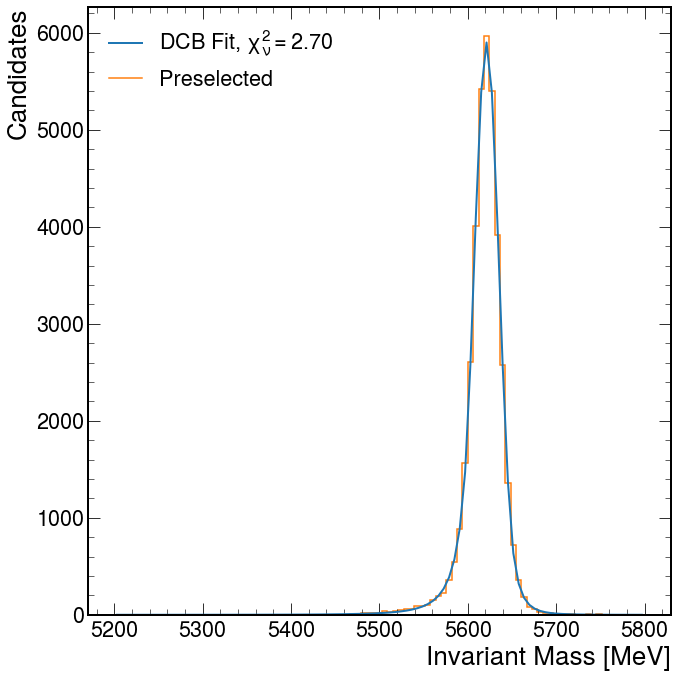

In [53]:
fig, ax = plt.subplots(1, 1)
labels = ['Preselected', 'No Preselection']
i = 0

for model, data in zip([model], [space]):
    allLimits = [data.data_range.limit1d[0], data.data_range.limit1d[1]]
    allLimits = np.array(allLimits)

    xBins = np.linspace(np.amin(allLimits), np.amax(allLimits), num=100) 
    x = (xBins[1:]+xBins[:-1])/2
    y = np.array([])
    nBinsLimit=0
    for a in range(int(allLimits.shape[0]/2)):
        nBinsLimit += len(x[(x>allLimits[a*2])&(x<allLimits[a*2+1])])
    
    y = np.append(y, model.pdf(x) * data.nevents.numpy() / nBinsLimit * np.sum(allLimits[1::2]-allLimits[::2]))

    ax.plot(x, y, linewidth=2, label=r'DCB Fit, $\chi^2_{\nu}=2.70$')
    data_plot = zfit.run(z.unstack_x(data))

    h, _ = np.histogram(data_plot, bins=xBins)
    hep.histplot(h, bins=xBins, ax=ax, label=labels[i])

    scaledDiff=(h[h!=0]-y[h!=0])/np.sqrt(h[h!=0])
    print("Chi2 = %.6g"%(np.sum(scaledDiff**2)/(len(scaledDiff)-len(model.get_params()))))
    i += 1
    
plt.ylabel('Candidates')
plt.xlabel('Invariant Mass [MeV]')
plt.legend()
plt.tight_layout()
plt.savefig('../images/signalfits/Unbinned_DCB_Preselected_Norm.png')
plt.show()